
## MACHINE LEARNING IN FINANCE
MODULE 7 | LESSON 4


---

# **BITCOIN TRADING STRATEGY**


|  |  |
|:---|:---|
|**Reading Time** |  30 minutes |
|**Prior Knowledge** | Hyperparameter tuning, supervised machine learning, classification algorithms  |
|**Keywords** |Bayesian optimization, signal  |


---

*In the last lesson, we discussed objective functions and extended our knowledge on hyperparameter tuning. In this lesson, we will train classification algorithms on a Bitcoin trading strategy problem and improve the performance of one machine learning model by tuning its parameters using grid search and Bayesian optimization techniques.*

## **1. Introduction**

In this problem we want to predict when to buy or sell Bitcoin. We will start by defining a *buy or sell signal* that will be represented by 1 or 0. We arrive at the signal by comparing the price trend of short-term and long-term behavior, that is, a short-term moving average greater than a long-term moving average. Then, we buy bitcoin; otherwise, we sell bitcoin. This is, therefore, a classification problem where we are interested in getting the direction of Bitcoin movement right. We will split our dataset into train and validation sets in the ratio of 4:1.

## **2. Loading Helper Packages and Data**

### **2.1 Loading Helper Packages**

We load the Python packages that will assist us in achieving our objective.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# from `keras.optimizers` import SGD

### **2.2 Data Loading**

We fetch Bitcoin data price from Yahoo finance for the last five years.

In [3]:
# To fetch financial data
import yfinance as yf

# Set the ticker as 'BTC-USD'
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="5y")

In [4]:
# BTC_Ticker = yf.Ticker("BTC-USD")
# BTC_Data = BTC_Ticker.history(period="max")
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-09-06 00:00:00+00:00,10578.198242,10898.761719,10292.299805,10353.302734,19536574783,0.0,0.0
2019-09-07 00:00:00+00:00,10353.931641,10558.673828,10348.918945,10517.254883,15307366476,0.0,0.0
2019-09-08 00:00:00+00:00,10518.114258,10595.637695,10409.090820,10441.276367,13670567493,0.0,0.0
2019-09-09 00:00:00+00:00,10443.228516,10450.311523,10144.929688,10334.974609,17595943368,0.0,0.0
2019-09-10 00:00:00+00:00,10336.408203,10394.353516,10020.573242,10115.975586,14906809639,0.0,0.0


### **3. Exploratory Data Analysis (EDA)**

This stage explores the data to help us see trends in the data.

In [5]:
BTC_Data.shape

(1828, 7)

In [6]:
BTC_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2019-09-06 00:00:00+00:00 to 2024-09-06 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1828 non-null   float64
 1   High          1828 non-null   float64
 2   Low           1828 non-null   float64
 3   Close         1828 non-null   float64
 4   Volume        1828 non-null   int64  
 5   Dividends     1828 non-null   float64
 6   Stock Splits  1828 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 114.2 KB


In [7]:
BTC_Data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.0,1828.0
mean,31810.013288,32511.166972,31058.967137,31832.509761,3.124437e+10,0.0,0.0
std,18555.062338,18984.595214,18069.066403,18554.406372,1.788576e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,5.331173e+09,0.0,0.0
25%,16645.569336,16805.792969,16456.881836,16663.950684,1.953892e+10,0.0,0.0
50%,29031.107422,29420.518555,28578.118164,29041.991211,2.793561e+10,0.0,0.0
75%,44914.045898,46603.070312,43673.244141,44959.245117,3.838120e+10,0.0,0.0
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11,0.0,0.0


In [8]:
# Checking for any null values and removing the null values'''
print("Null Values =", BTC_Data.isnull().values.any())

Null Values = False


## **4. Data Preparation**

We start by creating our target variable, that is, the buy or sell signal. The target variable constitutes our trading strategy. When the shorter term moving average goes above the longer term moving average, then it is an indicator to buy and the vice versa is also true. Read more here: [Picking buy-sell signals: A practitioner's perspective on key technical indicators for selected Indian firms.](https://sciendo.com/article/10.2478/sbe-2019-0054)

In [9]:
# Create short simple moving average over the short window
BTC_Data["short_moving_avg"] = (
    BTC_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

# Create long simple moving average over the long window
BTC_Data["long_maving_avg"] = (
    BTC_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

# Create signals
BTC_Data["signal"] = np.where(
    BTC_Data["short_moving_avg"] > BTC_Data["long_maving_avg"], 1.0, 0.0
)

In [10]:
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2019-09-06 00:00:00+00:00,10578.198242,10898.761719,10292.299805,10353.302734,19536574783,0.0,0.0,10353.302734,10353.302734,0.0
2019-09-07 00:00:00+00:00,10353.931641,10558.673828,10348.918945,10517.254883,15307366476,0.0,0.0,10435.278809,10435.278809,0.0
2019-09-08 00:00:00+00:00,10518.114258,10595.637695,10409.090820,10441.276367,13670567493,0.0,0.0,10437.277995,10437.277995,0.0
2019-09-09 00:00:00+00:00,10443.228516,10450.311523,10144.929688,10334.974609,17595943368,0.0,0.0,10411.702148,10411.702148,0.0
2019-09-10 00:00:00+00:00,10336.408203,10394.353516,10020.573242,10115.975586,14906809639,0.0,0.0,10352.556836,10352.556836,0.0


### **4.1 Feature Engineering**

We now create additional features in our dataset that will help improve our model performance. The additional features are:
1. Exponential Moving Average: This gives us the price trend of the data.
2. Relative Strength Indicator (RSI): RSI measures the change in prices in a recent time frame.
3. Rate of Change: This measures the percentage change between the stock's current price and past prices.
4. Stochastic Oscillator: This compares the current closing price of a stock with its previous closing prices.

In [11]:
# calculation of exponential moving average


def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA


BTC_Data["EMA10"] = EMA(BTC_Data, 10)
BTC_Data["EMA30"] = EMA(BTC_Data, 30)
BTC_Data["EMA200"] = EMA(BTC_Data, 200)
BTC_Data.head()


# calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


BTC_Data["RC10"] = RC(BTC_Data["Close"], 10)
BTC_Data["RC30"] = RC(BTC_Data["Close"], 30)


# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


BTC_Data["MOM10"] = MOM(BTC_Data["Close"], 10)
BTC_Data["MOM30"] = MOM(BTC_Data["Close"], 30)


# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


BTC_Data["RSI10"] = RSI(BTC_Data["Close"], 10)
BTC_Data["RSI30"] = RSI(BTC_Data["Close"], 30)
BTC_Data["RSI200"] = RSI(BTC_Data["Close"], 200)

# calculation of stochastic oscillator.


def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


BTC_Data["%K10"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%D10"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%K30"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%D30"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%K200"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)
BTC_Data["%D200"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)

We can display the dataframe to look at the features we have just feature-engineered.

In [12]:
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-02 00:00:00+00:00,57326.968750,59403.070312,57136.027344,59112.480469,27036454524,0.0,0.0,60384.047656,61315.054622,0.0,59564.732879,60428.791456,59573.964171,-7.894346,1.712931,-4981.875000,-1567.613281,45.807847,47.097304,51.587391,25.144452,14.383276,62.936231,58.220496,40.567259,37.955721
2024-09-03 00:00:00+00:00,59106.191406,59815.058594,57425.167969,57431.023438,26666961053,0.0,0.0,59709.250781,61327.865430,0.0,59176.785708,60235.387068,59552.641378,-10.729270,6.370575,-6747.968750,-685.953125,39.728824,45.095043,51.178144,3.752943,10.093834,52.344498,55.653482,33.740070,35.872966
2024-09-04 00:00:00+00:00,57430.347656,58511.570312,55673.164062,57971.539062,35627680312,0.0,0.0,59073.050391,61322.332096,0.0,58957.649954,60089.332358,59536.909016,-7.807044,3.457208,-6362.003906,3980.082031,42.456364,45.860437,51.302952,26.068891,18.322095,36.271539,50.517423,35.934716,36.747348
2024-09-05 00:00:00+00:00,57971.703125,58300.582031,55712.453125,56160.488281,31030280656,0.0,0.0,58401.033203,61327.521745,0.0,58449.075104,59835.858546,59503.312790,-5.619180,2.059022,-6720.171875,126.171875,36.334779,43.746636,50.865079,6.465216,12.095683,14.841878,34.485972,28.581339,32.752042
2024-09-06 00:00:00+00:00,56161.132812,56795.484375,55385.386719,55695.464844,31184072704,0.0,0.0,58020.166406,61310.694531,0.0,57948.418693,59568.736372,59465.423755,-5.645086,-9.746651,-3808.667969,668.003906,34.899165,43.217518,50.753292,5.347377,12.627161,9.078846,20.064088,26.693213,30.403089


In the next cell, we calculate the moving average.

In [13]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA


BTC_Data["MA21"] = MA(BTC_Data, 10)
BTC_Data["MA63"] = MA(BTC_Data, 30)
BTC_Data["MA252"] = MA(BTC_Data, 200)
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-02 00:00:00+00:00,57326.968750,59403.070312,57136.027344,59112.480469,27036454524,0.0,0.0,60384.047656,61315.054622,0.0,59564.732879,60428.791456,59573.964171,-7.894346,1.712931,-4981.875000,-1567.613281,45.807847,47.097304,51.587391,25.144452,14.383276,62.936231,58.220496,40.567259,37.955721,60384.047656,59551.414453,63744.619473
2024-09-03 00:00:00+00:00,59106.191406,59815.058594,57425.167969,57431.023438,26666961053,0.0,0.0,59709.250781,61327.865430,0.0,59176.785708,60235.387068,59552.641378,-10.729270,6.370575,-6747.968750,-685.953125,39.728824,45.095043,51.178144,3.752943,10.093834,52.344498,55.653482,33.740070,35.872966,59709.250781,59528.549349,63770.973574
2024-09-04 00:00:00+00:00,57430.347656,58511.570312,55673.164062,57971.539062,35627680312,0.0,0.0,59073.050391,61322.332096,0.0,58957.649954,60089.332358,59536.909016,-7.807044,3.457208,-6362.003906,3980.082031,42.456364,45.860437,51.302952,26.068891,18.322095,36.271539,50.517423,35.934716,36.747348,59073.050391,59661.218750,63802.516289
2024-09-05 00:00:00+00:00,57971.703125,58300.582031,55712.453125,56160.488281,31030280656,0.0,0.0,58401.033203,61327.521745,0.0,58449.075104,59835.858546,59503.312790,-5.619180,2.059022,-6720.171875,126.171875,36.334779,43.746636,50.865079,6.465216,12.095683,14.841878,34.485972,28.581339,32.752042,58401.033203,59665.424479,63822.705996
2024-09-06 00:00:00+00:00,56161.132812,56795.484375,55385.386719,55695.464844,31184072704,0.0,0.0,58020.166406,61310.694531,0.0,57948.418693,59568.736372,59465.423755,-5.645086,-9.746651,-3808.667969,668.003906,34.899165,43.217518,50.753292,5.347377,12.627161,9.078846,20.064088,26.693213,30.403089,58020.166406,59687.691276,63842.287598


We can now exclude features that are irrelevant for our prediction task such as the Bitcoin `High`, `Low` and `Open` values. Since we have already defined our trading signals, we drop the short and long moving average features.

In [14]:
# excluding columns that are not needed for our prediction.

BTC_Data = BTC_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [15]:
BTC_Data = BTC_Data.dropna(axis=0)

We can now visualize the Bitcoin price trend over the four years as shown in the figure below.

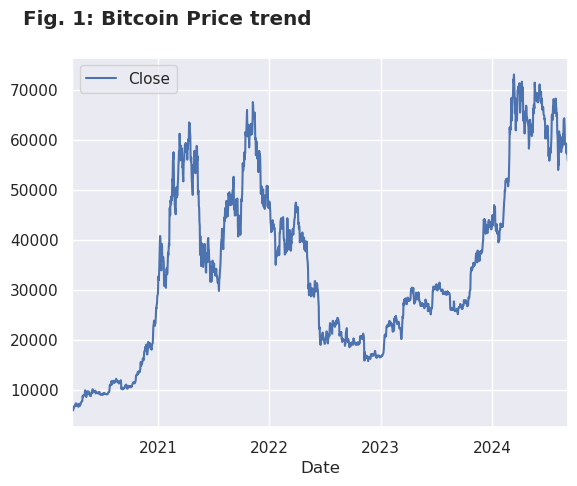

In [16]:
BTC_Data[["Close"]].plot(grid=True)
plt.suptitle(
    "Fig. 1: Bitcoin Price trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

In the cell below, we display the distribution of features that helps the modeler determine how to treat the individual features in our prediction dataset.

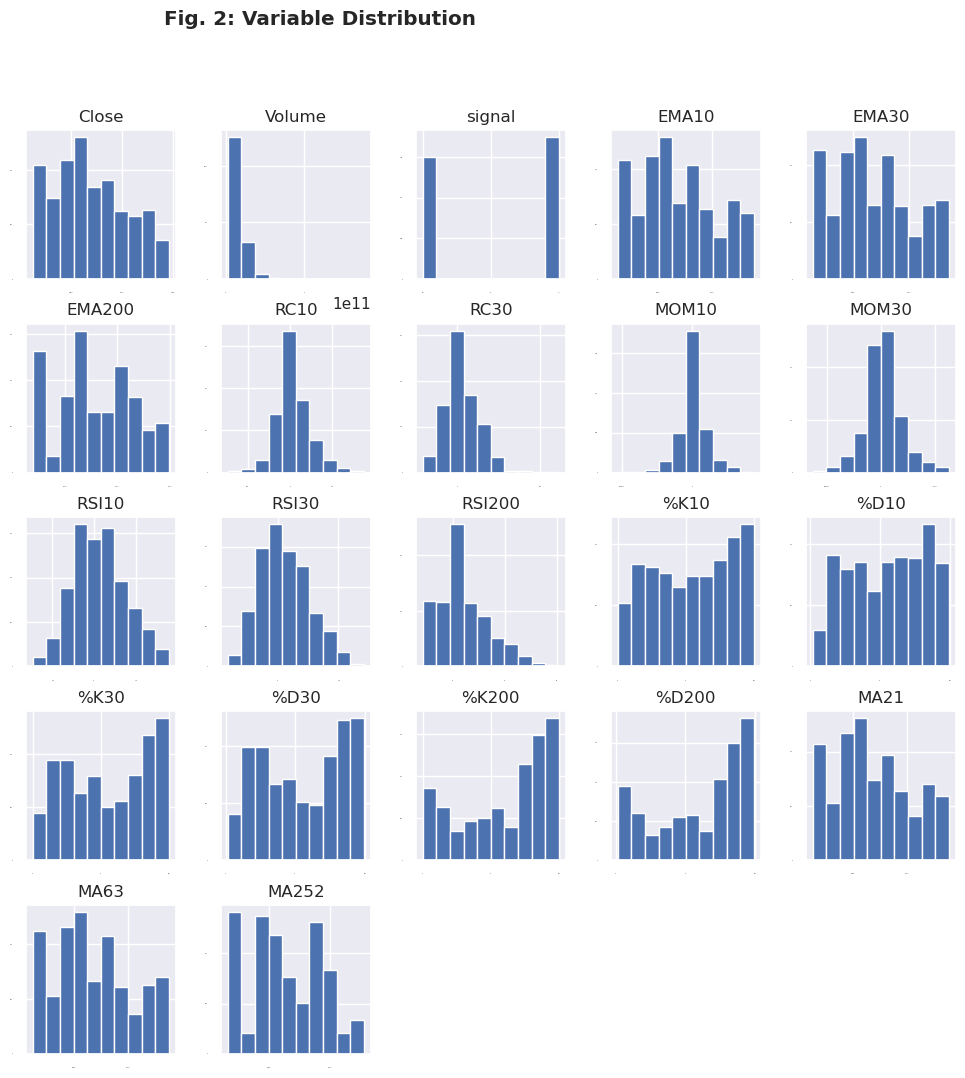

In [17]:
# histograms
BTC_Data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.suptitle(
    "Fig. 2: Variable Distribution", fontweight="bold", horizontalalignment="right"
)
plt.show()

Our interest as stated in the introduction is to predict when to buy or sell a Bitcoin. We draw a pie chart to visualize the proportion of sell to buy signals in our dataset.

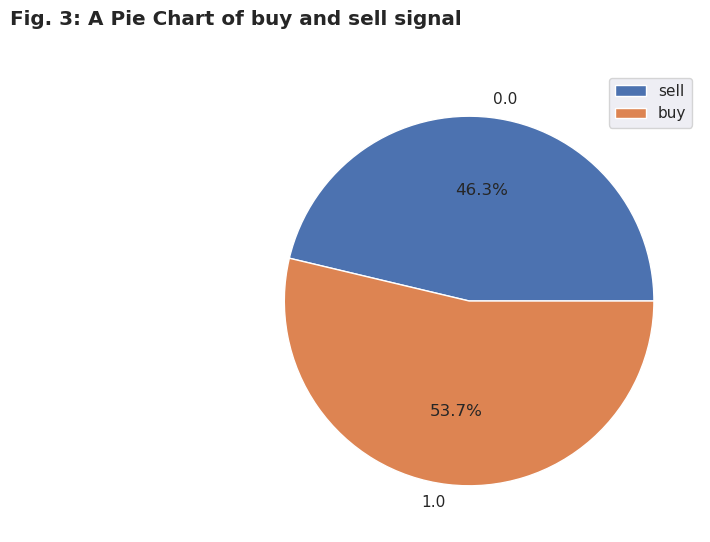

In [18]:
fig = plt.figure()
plot = (
    BTC_Data.groupby("signal")
    .size()
    .plot(kind="pie", figsize=(6, 6), autopct="%1.1f%%", y="Signal")
)
plt.suptitle(
    "Fig. 3: A Pie Chart of buy and sell signal",
    fontweight="bold",
    horizontalalignment="right",
)
plt.legend(["sell", "buy"])
plt.show()

The count of this signals can also be seen below.

In [19]:
BTC_Data.groupby(["signal"]).size()

signal
0.0    753
1.0    874
dtype: int64

We can now look at the relationship between our variables using a correlation matrix of the returns.

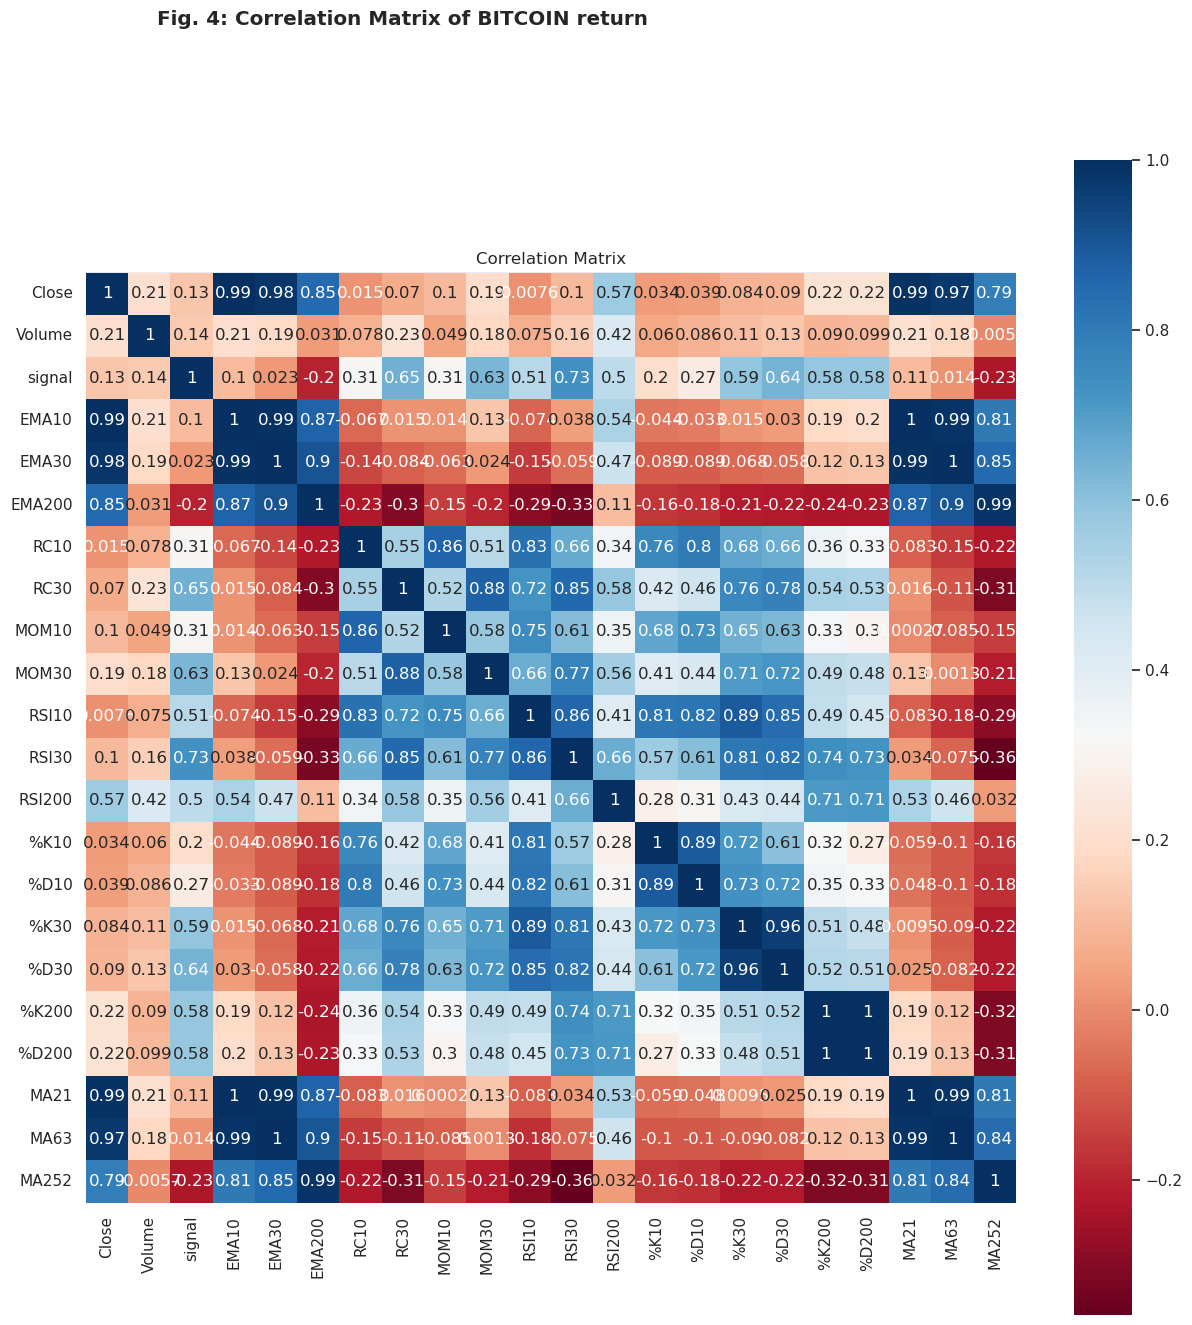

In [20]:
# correlation
BTC_data_returns = BTC_Data.shift(1)
correlation = BTC_data_returns.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="RdBu")
plt.suptitle(
    "Fig. 4: Correlation Matrix of BITCOIN return",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

## **5. Modeling**

Now that we have our dataset in place, we split our dataset into a training and a holdout set, in our case the test set that will be used to backtest on our model. 

### **5.1 Train test Split**

We start our modeling by splitting the dataset into train and test sets in the ratio of 80:20.

In [21]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values("Date").unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start:cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start:holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [22]:
subset_validation = BTC_Data[1301:]

In [23]:
subset_validation.shape

(326, 22)

In [24]:
# split out validation dataset for the end
subset_dataset = BTC_Data[:1300]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, BTC_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)

In [25]:
subset_dataset.shape

(1300, 22)

We create a **validation** dataset that consists of the remaining data we did not pick in the subset dataset. This validation dataset will only be used in backtesting our models.

In [26]:
subset_validation = BTC_Data[1300:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, BTC_Data.columns != "signal"]

In [27]:
X_validation.shape

(327, 21)

### **5.1 Baseline Classifier**

As discussed in the previous module, it is important to train a baseline classifier that will be used as a baseline to compare with the real classifiers we will use for this task. We will use `sklearn` [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) as our baseline classifier and choose `strategy=stratified` that predicts the most frequent class.

We start by defining our evaluation metrics.

In [28]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuracy": "Accuracy",
    "roc_auc": "AUC",
    "neg_log_loss": "Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision",
    "recall_weighted": "Recall",
}

We define a cross-validation function that will help us evaluate different algorithms.

In [29]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=10, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(
        estimator=clf,
        X=X,
        y=y,
        scoring=list(metrics.keys()),
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1,
        fit_params=fit_params,
    )
    duration = time() - start
    return scores, duration

We also define a function that will help us manipulate the cross-validation output and plot them as will be seen in examples applied in this lesson.

In [30]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split("_", 1)) for m in scores.keys()], names=["Dataset", "Metric"]
    )
    data = np.array(list(scores.values())).T
    df = pd.DataFrame(data=data, columns=columns).iloc[:, 2:]
    results = pd.melt(df, value_name="Value")
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

We finally define a plot function that will display the metrics of our models as box plots so as to allow us to visualize the distribution of the model performance.

In [31]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(
        x="Dataset",
        y="Value",
        hue="Dataset",
        col="Metric",
        data=df,
        col_order=m,
        order=["Train", "Test"],
        kind="box",
        col_wrap=3,
        sharey=False,
        height=4,
        aspect=1.2,
    )
    df = df.groupby(["Metric", "Dataset"]).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(
            0.05,
            0.85,
            s,
            fontsize=10,
            transform=ax.transAxes,
            bbox=dict(facecolor="white", edgecolor="grey", boxstyle="round,pad=0.5"),
        )
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=0.9)
    if fname:
        g.savefig(fname, dpi=300);

We now start by defining the dummy classifier as shown below.

In [32]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
algo = "dummy_clf"

We run the dummy classifier using cross-validation with the defined metrics used to measure model performance.

In [33]:
fname = f"{algo}.joblib"

dummy_cv_result, run_time_algo = run_cv(dummy_clf)
joblib.dump(dummy_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.4s finished


['dummy_clf.joblib']

We can now create a table with the model performance on each metric as shown below.

In [34]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.509835,0.513585
Accuracy,0.509835,0.513585
F1,0.509904,0.513603
Log Loss,-17.661390,-17.532003
Precision,0.509924,0.513642
Recall,0.510000,0.513590


Clearly, the model performance is kind of guess work as the model is half-right nearly all the time with its model metrics showing a very naïve model, as we expected. This performance will act as our baseline, and when building a model, we strive to get a model that outperforms the dummy classifier. In the next cell, we visualize the above metrics using box plots.

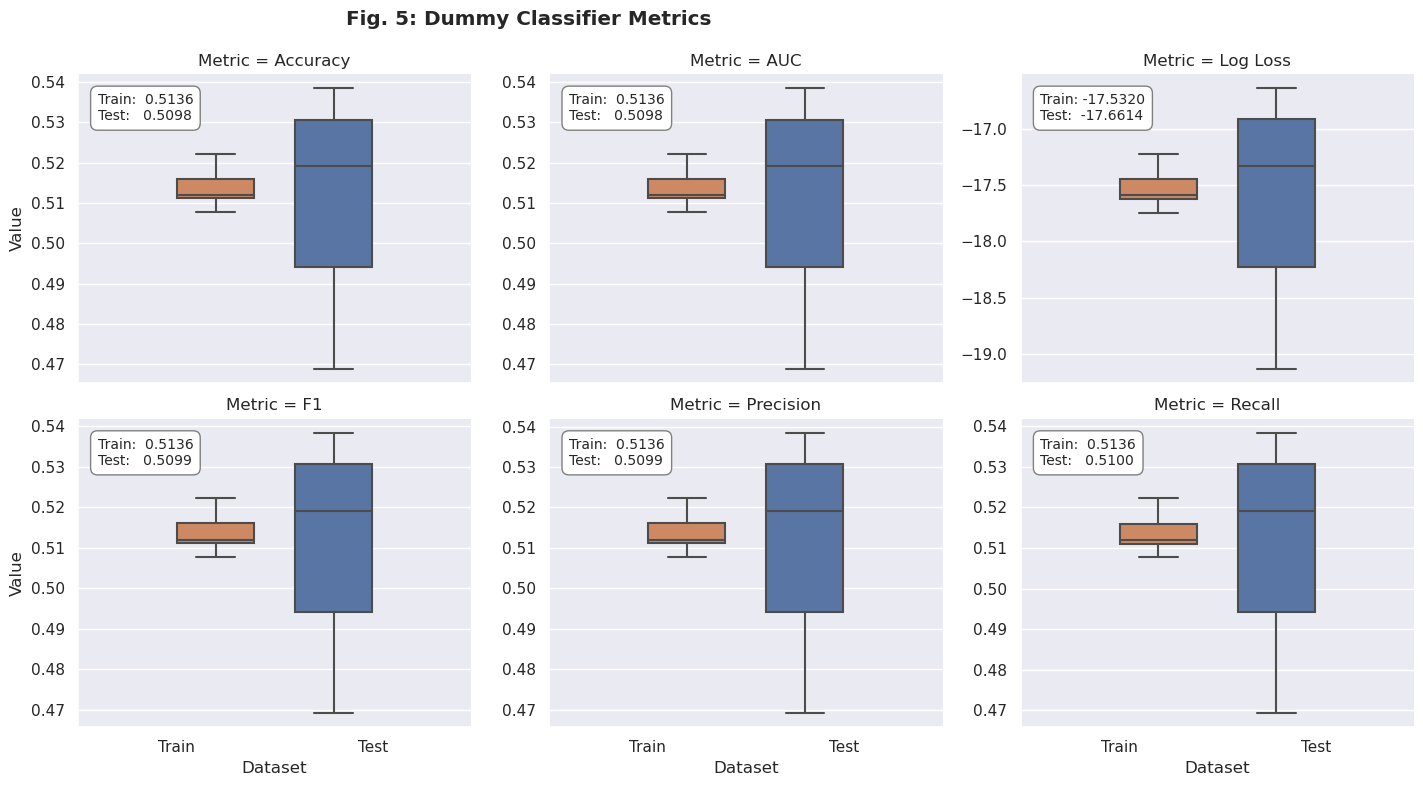

In [35]:
plot_result(dummy_result, model="Dummy Classifier")
plt.suptitle(
    "Fig. 5: Dummy Classifier Metrics", fontweight="bold", horizontalalignment="right"
)
plt.show()

We can now starting searching for better models that will be used to beat the dummy classifier.

### **5.2 Defining the Classification Algorithms**

We start by defining several models that will be evaluated and we select one of them.

In [36]:
# spot check the algorithms
models = []
models.append(("LR", LogisticRegression(n_jobs=-1)))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# Neural Network
models.append(("NN", MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(("AB", AdaBoostClassifier()))
models.append(("GBM", GradientBoostingClassifier()))
# Bagging methods
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

We now evaluate these models' performance using `kFold` cross-validation and record their mean and variance.

In [37]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.511538 (0.041201)
LDA: 0.933654 (0.028345)
KNN: 0.531731 (0.046324)
CART: 0.900962 (0.025458)
NB: 0.550000 (0.039129)
NN: 0.492308 (0.042089)
AB: 0.940385 (0.023474)
GBM: 0.947115 (0.017334)
RF: 0.945192 (0.026872)


Looking at the outputs recorded above, Random Forest Classifier outperforms the other models, and we select it as our preferred model. We can also visualize the performance of the algorithms in a box plot as shown below.

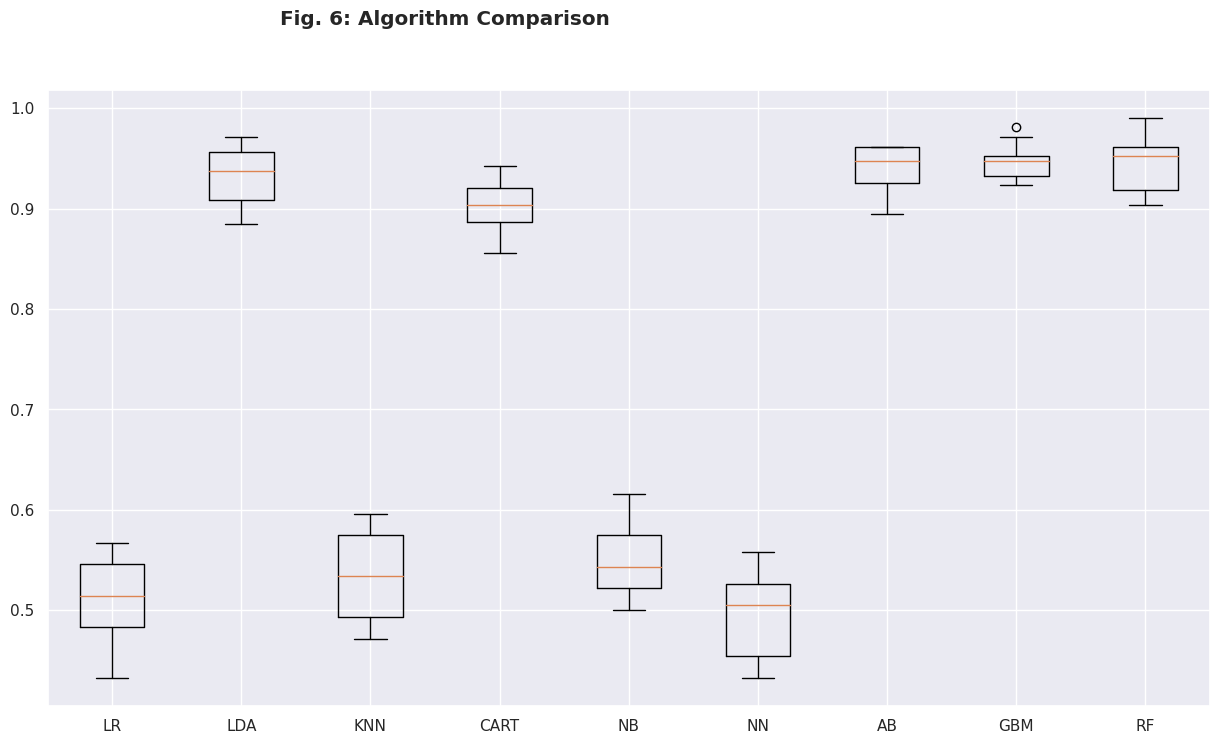

In [38]:
# compare algorithms
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.suptitle(
    "Fig. 6: Algorithm Comparison", fontweight="bold", horizontalalignment="right"
)
plt.show()

## **6. Hyperparameter Tuning**

Since random forest was our best performer, we seek to tune its hyperparameters to improve the performance even further.

### **6.1 Grid Search**

In [39]:
# Grid Search: Random Forest Classifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20, 80]
max_depth = [5, 10]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.949038 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#6 0.929808 (0.025092) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#8 0.925962 (0.033323) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.944231 (0.028782) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#4 0.942308 (0.022344) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.926923 (0.038269) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.931731 (0.028345) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#2 0.947115 (0.025166) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.949038 (0.023177) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


We can now fix the best hyperparameters to our model and use it to compare with the dummy classifier. We repeat the same steps as in the dummy classifier problem.

In [40]:
# prepare model
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)  # `rbf` is default kernel

In [41]:
algo_forest = "random_forest"

In [42]:
fname = f"{algo_forest}.joblib"

random_forest_cv_result, run_time_algo_forest = run_cv(model)
joblib.dump(random_forest_cv_result, fname)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.5s finished


['random_forest.joblib']

We can now display the model performance table below.

In [43]:
rf_result = stack_results(random_forest_cv_result)
rf_result.groupby(["Metric", "Dataset"]).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.913617,1.000000
Accuracy,0.828739,0.999746
F1,0.823608,0.999744
Log Loss,-0.422628,-0.042463
Precision,0.853610,0.999744
Recall,0.828462,0.999744


The cell below displays the above metrics as box plots.

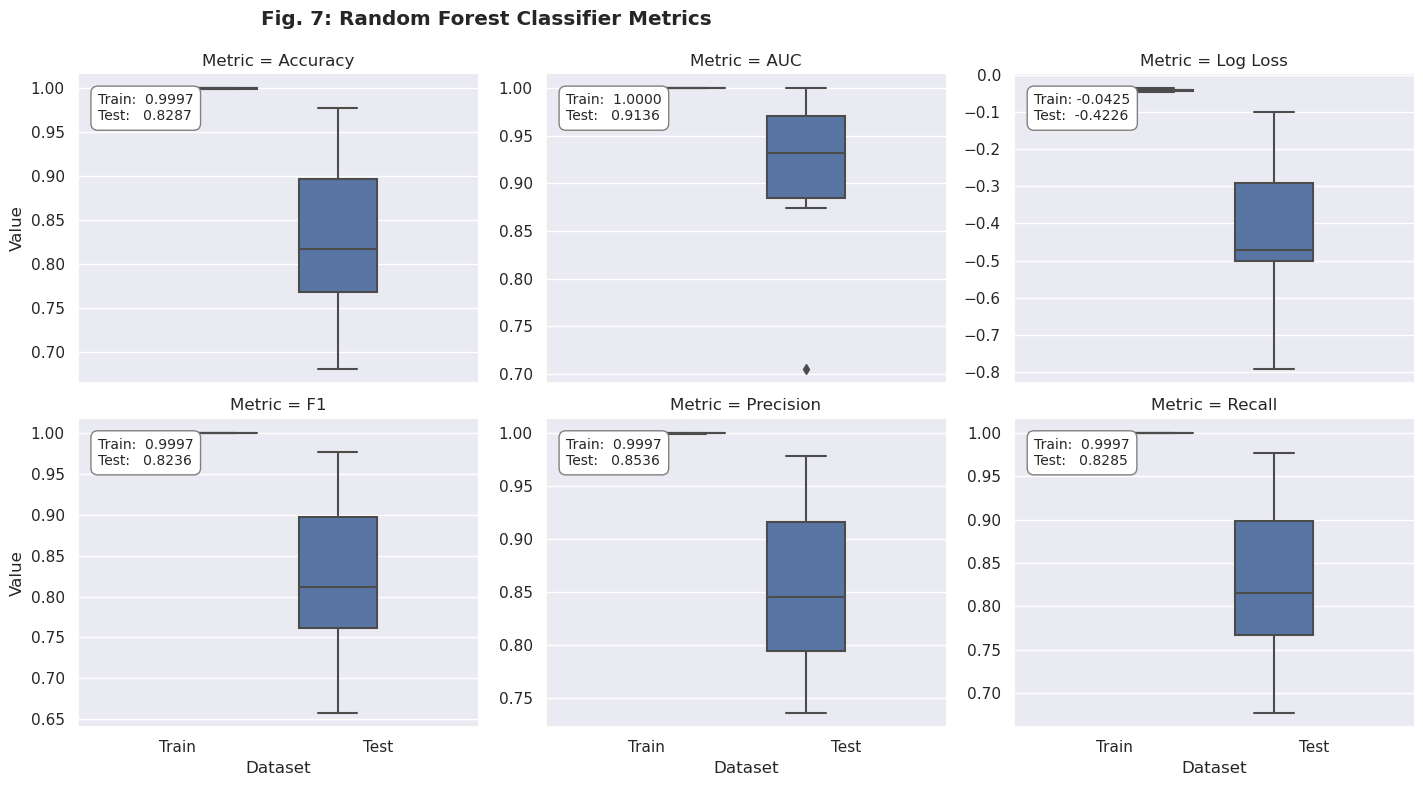

In [44]:
plot_result(rf_result, model="Random Forest Classifier")
plt.suptitle(
    "Fig. 7: Random Forest Classifier Metrics",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

Clearly, random forest classifier outperforms the dummy classifier by far, but we seem to face a problem of overfitting. In the prediction task, we would like to look at ways of mitigating this. The table below shows a comparison of the random forest classifier and the dummy classifier.

In [45]:
results = {
    "Baseline": dummy_result,
    "Random Forest": rf_result,
}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat(
        [
            df,
            result.groupby(["Metric", "Dataset"])
            .Value.mean()
            .unstack()["Test"]
            .to_frame(model),
        ],
        axis=1,
    )

df.T.sort_values("AUC", ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Random Forest,0.913617,0.828739,0.823608,-0.422628,0.853610,0.828462
Baseline,0.509835,0.509835,0.509904,-17.661390,0.509924,0.510000


Having settled on random forest, we can now train it on the data and analyze its performance on the holdout dataset.

In [46]:
model = RandomForestClassifier(
    criterion="gini", n_estimators=80, max_depth=10, n_jobs=-1
)
model.fit(X_train, y_train)
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9076923076923077
[[124  11]
 [ 13 112]]
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       135
         1.0       0.91      0.90      0.90       125

    accuracy                           0.91       260
   macro avg       0.91      0.91      0.91       260
weighted avg       0.91      0.91      0.91       260



The model shows a better prediction potential on the holdout dataset with performance being upwards of $94\%$.<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

To evaluate the model's performance, we can draw the confusion matrix that allows us to visualize the models' recall, specificity, accuracy, and precision.

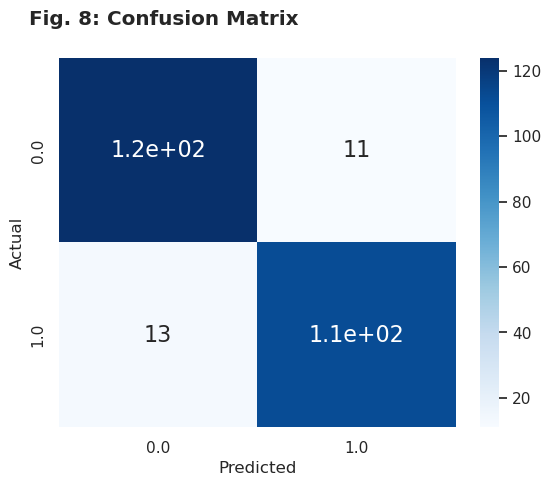

In [47]:
df_cm = pd.DataFrame(
    confusion_matrix(y_test, predictions),
    columns=np.unique(y_test),
    index=np.unique(y_test),
)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
plt.suptitle("Fig. 8: Confusion Matrix", fontweight="bold", horizontalalignment="right")
plt.show()

We determine the variables with more predictive powers as shown below.

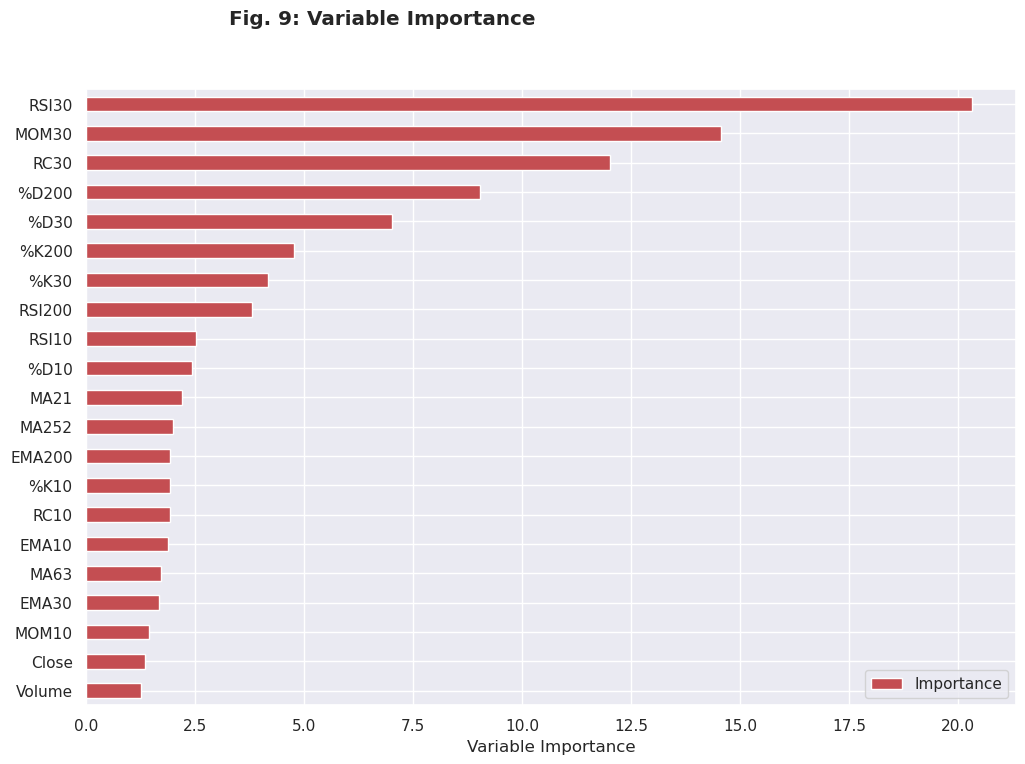

In [48]:
Importance = pd.DataFrame(
    {"Importance": model.feature_importances_ * 100}, index=X.columns
)
Importance.sort_values("Importance", axis=0, ascending=True).plot(
    kind="barh", color="r", figsize=(12, 8)
)
plt.xlabel("Variable Importance")
plt.suptitle(
    "Fig. 9: Variable Importance", fontweight="bold", horizontalalignment="right"
)
plt.show()

### **6.2 Bayesian Optimization**

The Bayesian optimization process uses the Gaussian process to model the mean and variance of our objective function. In every iteration, it tries different combinations of hyperparameter values and builds a new model by using the model's past information. This has the advantage of reducing training time to achieve better results.

We start by defining the stratified `kFold` function that will be used to perform cross-validation on the training dataset.

In [49]:
def stratified_kfold_score(clf, X_train, y_train, n_fold):
    X, y = X_train.values, y_train.values
    strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in strat_kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds, y_test_fold)
        accuracy_list.append(accuracy_test)

    return np.array(accuracy_list).mean()

We also define a function with the model hyperparameters we would like to tune, that is, `max_samples`, `max_features` and `n_estimators`.

In [50]:
def bo_params_rf(max_samples, n_estimators, max_features):
    params = {
        "max_samples": max_samples,
        "max_features": max_features,
        "n_estimators": int(n_estimators),
    }
    clf = RandomForestClassifier(
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        n_estimators=params["n_estimators"],
    )
    score = stratified_kfold_score(clf, X_train, y_train, 5)
    return score

In the cell that follows, we give a range of hyperparameter space that the Bayesian optimization will search.

In [51]:
rf_bo = BayesianOptimization(
    bo_params_rf,
    {"max_samples": (0.2, 1), "max_features": (0.5, 1), "n_estimators": (50, 200)},
)

We can now apply Bayesian optimization to search through the hyperparameter space and output the results at each iteration. The cell below outputs the performance for each hyperparameter combination it finds and labels in blue the combination with a higher score than the previous combinations it has already selected.

In [52]:
results = rf_bo.maximize(n_iter=200, init_points=20, acq="ei")

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------


/tmp/ipykernel_2418/3710065653.py:1: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  results = rf_bo.maximize(n_iter=200, init_points=20, acq="ei")


| 1         | 0.9413    | 0.5472    | 0.7767    | 132.5     |
| 2         | 0.9375    | 0.8062    | 0.8386    | 130.1     |
| 3         | 0.9298    | 0.9457    | 0.3738    | 115.1     |
| 4         | 0.9375    | 0.9881    | 0.7239    | 129.6     |
| 5         | 0.9404    | 0.6646    | 0.9481    | 118.2     |
| 6         | 0.9413    | 0.5736    | 0.928     | 134.3     |
| 7         | 0.9394    | 0.5312    | 0.8941    | 102.9     |
| 8         | 0.9365    | 0.5256    | 0.5389    | 99.99     |
| 9         | 0.9327    | 0.5815    | 0.374     | 113.6     |
| 10        | 0.9423    | 0.7921    | 0.954     | 142.9     |
| 11        | 0.9356    | 0.8531    | 0.2991    | 108.1     |
| 12        | 0.9394    | 0.5888    | 0.5901    | 141.6     |
| 13        | 0.9346    | 0.9785    | 0.5758    | 92.63     |
| 14        | 0.9375    | 0.5664    | 0.447     | 126.2     |
| 15        | 0.9269    | 0.9259    | 0.2129    | 180.1     |
| 16        | 0.9337    | 0.8619    | 0.4471    | 129.2     |
| 17    

We can now display the best hyperparameters that have been encountered by Bayesian optimization.

In [53]:
params = rf_bo.max["params"]
params["n_estimators"] = int(params["n_estimators"])
print(params)

{'max_features': 0.5011013497961576, 'max_samples': 0.8371237435757386, 'n_estimators': 64}


We can now fix these hyperparameters on our model as shown below.

In [54]:
rf_v1 = RandomForestClassifier(
    max_samples=params["max_samples"],
    max_features=params["max_features"],
    n_estimators=params["n_estimators"],
)

We now use our training dataset to train the above model having the best selected hyperparameters.

In [55]:
rf_v1.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5011013497961576,
                       max_samples=0.8371237435757386, n_estimators=64)

From the model we have trained above, we use that to predict on the holdout dataset and evaluate the model performance using the classification report.

In [56]:
preds = rf_v1.predict(X_test)

In [57]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       137
         1.0       0.92      0.93      0.93       123

    accuracy                           0.93       260
   macro avg       0.93      0.93      0.93       260
weighted avg       0.93      0.93      0.93       260



The classification report above shows that the model correctly predicts the signals with a high precision. We can print out the values of precision score, recall score, and f1 score to better shed light on the classification report.

In [58]:
print("Precision:{}".format(precision_score(preds, y_test)))
print("Recall:{}".format(recall_score(preds, y_test)))
print("F1 Score:{}".format((f1_score(preds, y_test))))

Precision:0.92
Recall:0.9349593495934959
F1 Score:0.9274193548387097


As alluded, we get high performance on the classification report. Can we improve the model performance? Let's implement the stratified `kFold` validation below.

In [59]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
scores = []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    rf_v1.fit(X.iloc[train], y.iloc[train])
    preds = rf_v1.predict(X_train.iloc[test])
    accuracy = accuracy_score(preds, y_train.iloc[test])
    scores.append(accuracy)

df_val = pd.DataFrame(scores, columns=["Accuracy Test"])
print(
    "KFold validation mean accuracy on test set : {}".format(
        df_val["Accuracy Test"].mean()
    )
)

KFold validation mean accuracy on test set : 0.9673076923076923


The accuracy on the test dataset shows a comparable result with what we have seen so far.

### **7. Backtesting**

We now want to see how our trading strategy would perform on historical data, and this is possible with the help of backtesting. Backtesting allows us to simulate how we would have performed in the past without using any financial capital. 

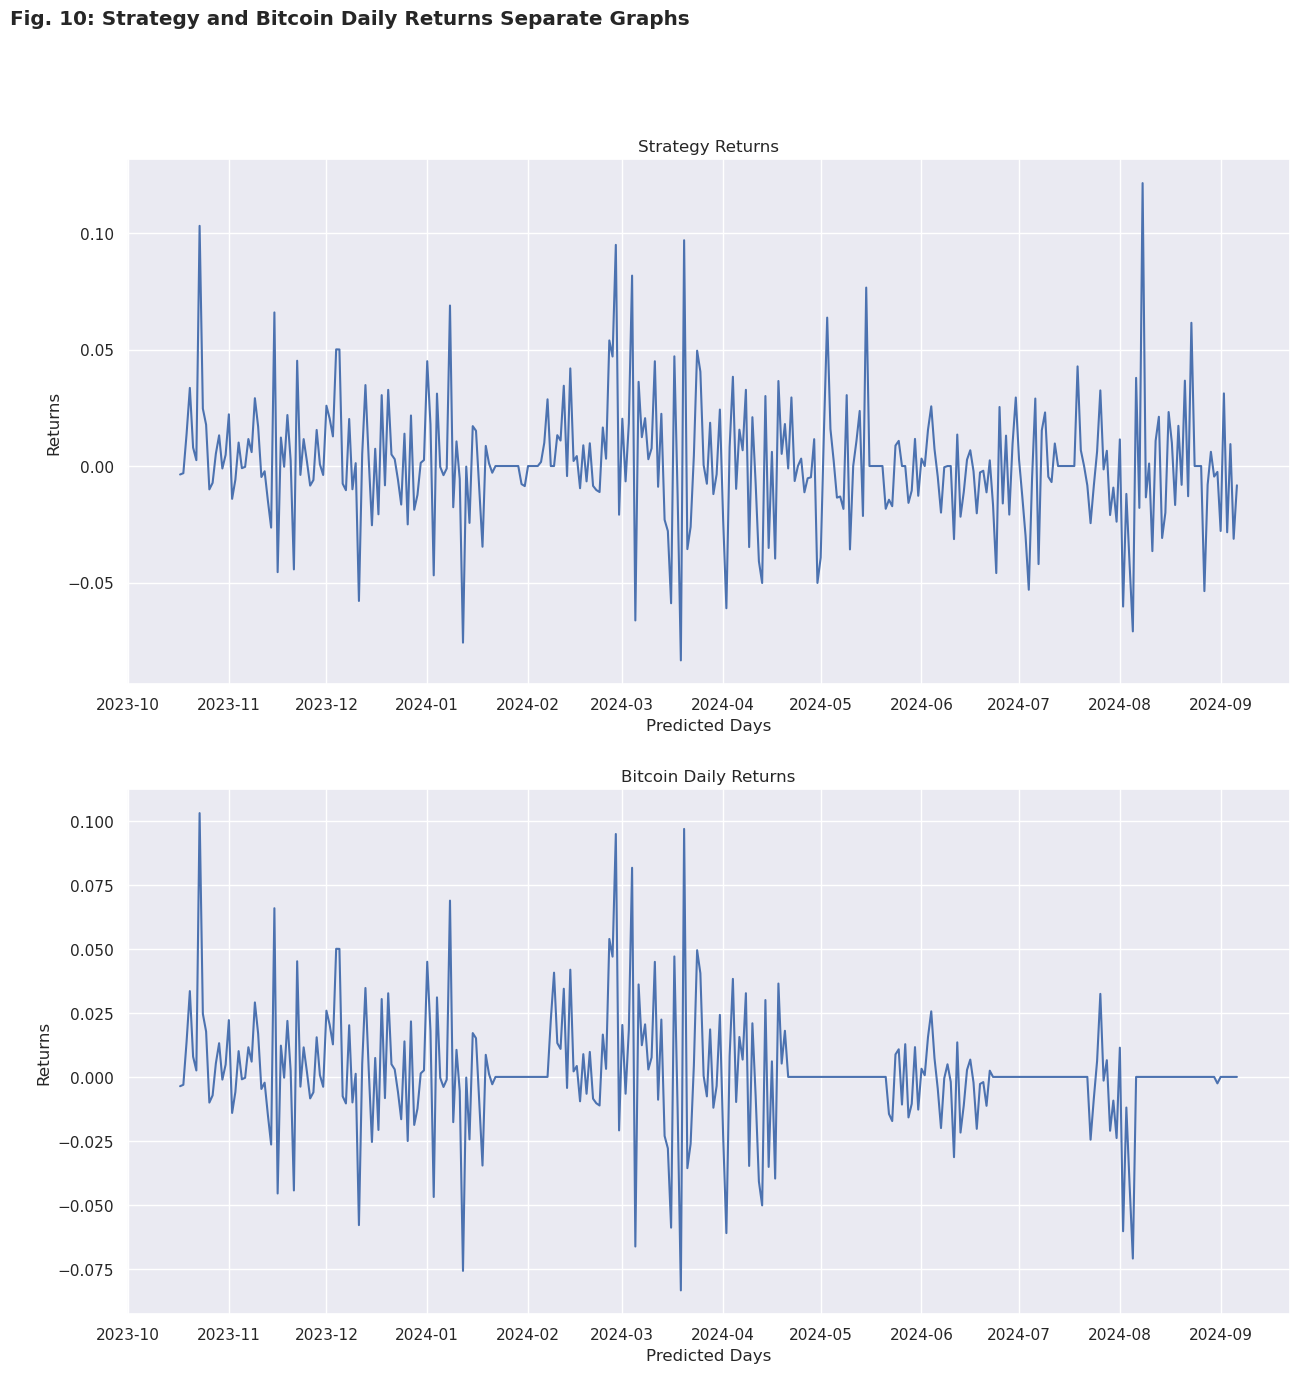

In [60]:
# Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
# of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
validation_prediction = rf_v1.predict(X_validation)
backtestdata["signal_pred"] = validation_prediction
backtestdata["signal_actual"] = y_validation
backtestdata["Market Returns"] = X_validation["Close"].pct_change()
backtestdata["Actual Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_actual"
].shift(1)
backtestdata["Strategy Returns"] = backtestdata["Market Returns"] * backtestdata[
    "signal_pred"
].shift(1)
# backtestdata=backtestdata.reset_index()
backtestdata.head()

fig, axs = plt.subplots(2, figsize=(15, 15))
fig.suptitle("Vertically stacked subplots")
axs[0].plot(backtestdata["Strategy Returns"])
axs[0].set_title("Strategy Returns")
axs[1].plot(backtestdata["Actual Returns"])
axs[1].set_title("Bitcoin Daily Returns")

for ax in axs.flat:
    ax.set(xlabel="Predicted Days", ylabel="Returns")

# `backtestdata`[['Strategy Returns','Actual Returns']].plot()
# `plt.title`('Cumulative Strategy Returns vs Cumulative Actual Returns')
plt.suptitle(
    "Fig. 10: Strategy and Bitcoin Daily Returns Separate Graphs",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

In the above diagrams, we visualize the strategy and Bitcoin daily returns in two separate figures. We put the above figures on the same figure below.

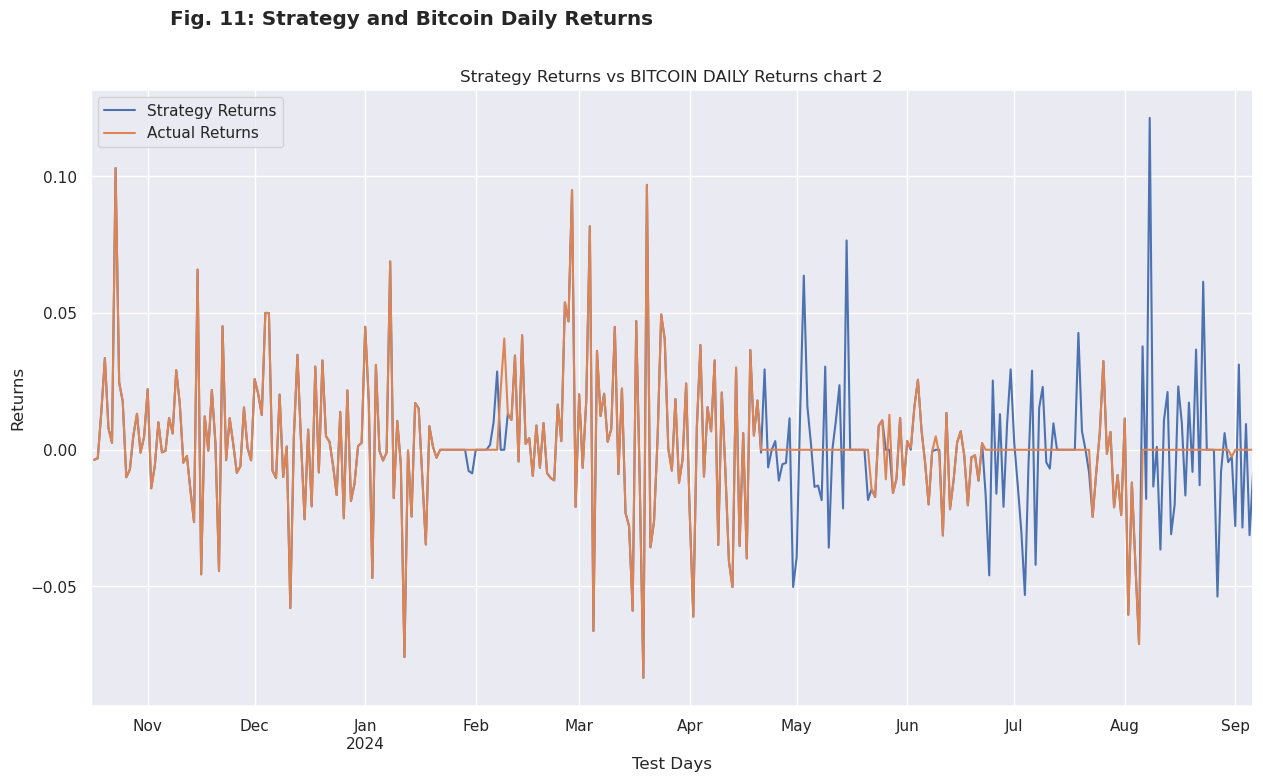

In [61]:
backtestdata[["Strategy Returns", "Actual Returns"]].plot(figsize=(15, 8))
plt.title("Strategy Returns vs BITCOIN DAILY Returns chart 2")
plt.suptitle(
    "Fig. 11: Strategy and Bitcoin Daily Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.xlabel("Test Days")
plt.ylabel("Returns")
plt.show()

We can clearly see that the strategy and Bitcoin daily return are identical on most test days with the exception of very few days. We can now plot the cumulative returns for both strategy returns and the Bitcoin returns to compare how we expect to perform in the near future if we applied our trading model.

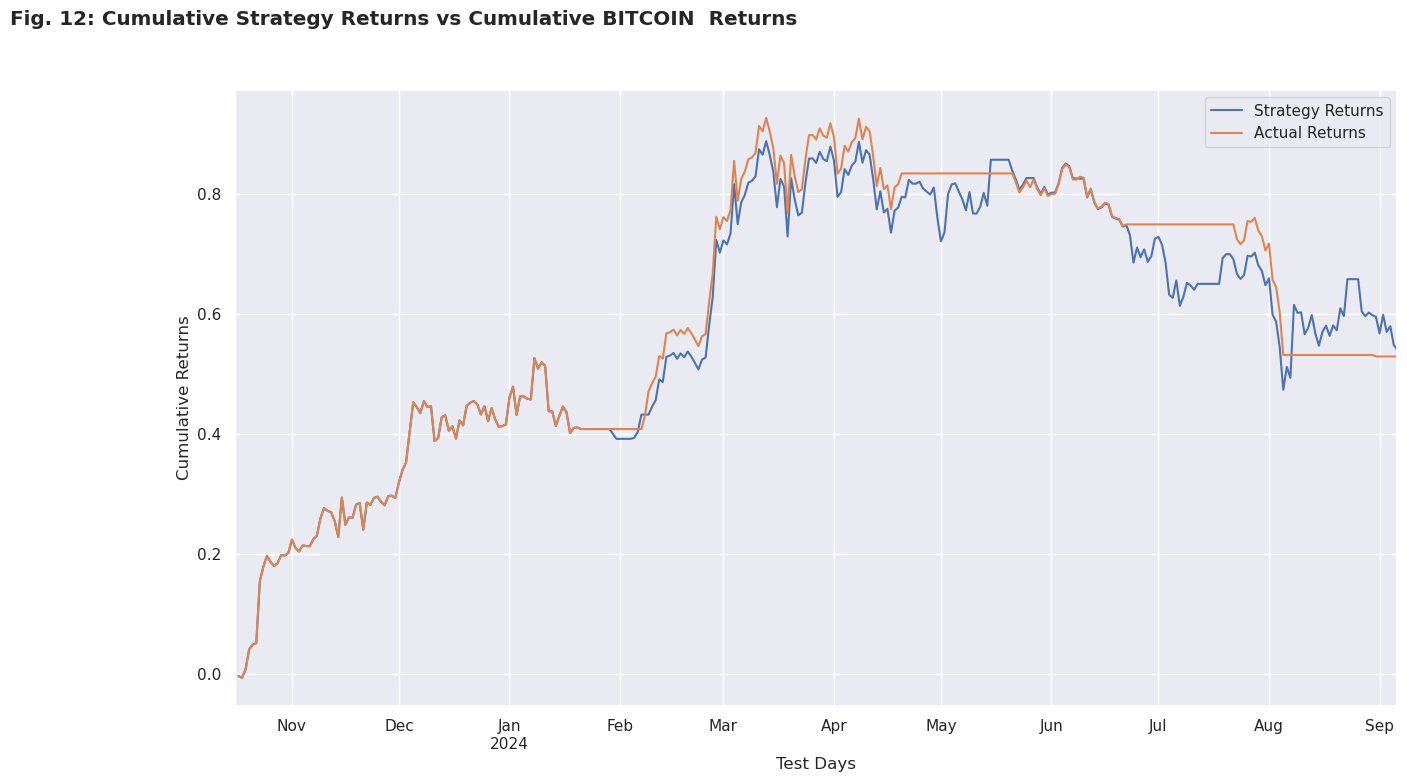

In [62]:
backtestdata[["Strategy Returns", "Actual Returns"]].cumsum().plot(figsize=(15, 8))
plt.xlabel("Test Days")
plt.ylabel("Cumulative Returns")
plt.suptitle(
    "Fig. 12: Cumulative Strategy Returns vs Cumulative BITCOIN  Returns",
    fontweight="bold",
    horizontalalignment="right",
)
plt.show()

## **7. Conclusion**

In this lesson, we have learned how to apply Bayesian optimization and grid search on our model to improve performance. We also saw how to use baseline models as a reference to the models we will use to predict the buy or sell signals. We anticipate that more could be done to better improve the model, and we ask the students to explore more.


**References**

1. Snoek, Jasper, et al. "Practical Bayesian Optimization of Machine Learning Algorithms." *Advances in Neural Information Processing Systems*, vol. 25, 2012.
2. Shalini, Talwar, Shah Pranav, and Shah Utkarsh. "Picking buy-sell signals: A practitioner's perspective on key technical indicators for selected Indian firms." Studies in Business & Economics 14.3 (2019).
3. Bergstra, James, et al. "Algorithms for Hyper-parameter Optimization." *Advances in Neural Information Processing Systems*, vol. 24, 2011. https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf

---
Copyright 2024 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
